## Getting Started

We begin by importing STUMPY, some relevant packages for loading and analyzing the data.

In [3]:
import stumpy

# Data loading
from scipy.io import loadmat
from zipfile import ZipFile
from urllib.request import urlopen
import io
import ssl

# Data processing, clustering and plotting
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy import signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


## Loading the data

We load the data from the [companion website](https://sites.google.com/site/mpdistinfo) of the MPdist paper as pandas dataframes. The dataset is for handwriting data for some common female names.

In [13]:
context = ssl.SSLContext()  # Ignore SSL certificate verification for simplicity

fzip = ZipFile(io.BytesIO(urlopen("https://sites.google.com/site/mpdistinfo/home/words_dendrogram.zip?attredirects=0&d=1").read()))
mat = fzip.extract("words_dendrogram/LisaBeth/MaryBethAnhLisa_data.mat")
data = loadmat(mat)

dfs = {}
for i in range(data['XSsY4'][0].shape[0]):
    name = data['XSsY4'][1][i][0]
    df = pd.DataFrame(data['XSsY4'][0][i].flatten(), columns=[name])
    dfs[name] = df

labels = [None] * len(dfs)

for i, (k, v) in enumerate(dfs.items()):
    name = k.replace("nh", "nne") # for some reason "nne" seems to be replaced by "nh" in the names
    labels[i] = name

We then plot these time series. Each time series corresponds to a single name indicated on the right. The plot represents the Y-axis over time as the names are written out in cursive form.

In [33]:
def euc_1(t_1, t_2):
    # euclidean distance of the smaller with mean padding at the end
    if t_1.shape[0] > t_2.shape[0]:
        x = t_2
        t_2 = t_1
        t_1 = x
    for i in range(t_2.shape[0] - t_1.shape[0]): # sliding over the longer 
        x = np.ones(t_2.shape) * np.mean(t_1)
        x[: t_1.shape[0]] = t_1
    return np.linalg.norm(x - t_2)

def euc_2(t_1, t_2):
    # euclidean distance of the smaller with mean padding at the beginning
    if t_1.shape[0] > t_2.shape[0]:
        x = t_2
        t_2 = t_1
        t_1 = x
    for i in range(t_2.shape[0] - t_1.shape[0]): # sliding over the longer 
        x = np.ones(t_2.shape) * np.mean(t_1)
        x[t_2.shape[0]-t_1.shape[0]:] = t_1
    return np.linalg.norm(x - t_2)

def euc_3(t_1, t_2):
    # minimum of rolling euclidean distance of the smaller against the larger (assuming phase-invariance)
    if t_1.shape[0] > t_2.shape[0]:
        x = t_2
        t_2 = t_1
        t_1 = x
    t_2 = np.concatenate((t_2, t_2))
    
    dists = []
    for i in range(t_2.shape[0] - t_1.shape[0]): # sliding over the longer 
        dists.append(np.linalg.norm(t_1 - t_2[i : i + t_1.shape[0]]))
    return min(dists)

def euc_4(t_1, t_2):
    # minimum of rolling euclidean distance of the smaller against the larger
    if t_1.shape[0] > t_2.shape[0]:
        x = t_2
        t_2 = t_1
        t_1 = x
    
    dists = []
    for i in range(t_2.shape[0] - t_1.shape[0]): # sliding over the longer 
        dists.append(np.linalg.norm(t_1 - t_2[i : i + t_1.shape[0]]))
    return min(dists)


def euc_5(t_1, t_2):
    # euclidean distance of the smaller with zero padding at the end
    if t_1.shape[0] > t_2.shape[0]:
        x = t_2
        t_2 = t_1
        t_1 = x
    for i in range(t_2.shape[0] - t_1.shape[0]): # sliding over the longer 
        x = np.zeros(t_2.shape)
        x[: t_1.shape[0]] = t_1
    return np.linalg.norm(x - t_2)

def euc_6(t_1, t_2):
    # euclidean distance of the smaller with zero padding at the beginning
    if t_1.shape[0] > t_2.shape[0]:
        x = t_2
        t_2 = t_1
        t_1 = x
    for i in range(t_2.shape[0] - t_1.shape[0]): # sliding over the longer 
        x = np.zeros(t_2.shape)
        x[t_2.shape[0]-t_1.shape[0]:] = t_1
    return np.linalg.norm(x - t_2)

def euc_7(t_1, t_2):
    # euclidean distance of the longer trucated at the end
    if t_1.shape[0] > t_2.shape[0]:
        x = t_2
        t_2 = t_1
        t_1 = x
    return np.linalg.norm(t_1 - t_2[:t_1.shape[0]])

def euc_8(t_1, t_2):
    # euclidean distance of the longer truncated at the beginning
    if t_1.shape[0] > t_2.shape[0]:
        x = t_2
        t_2 = t_1
        t_1 = x
    return np.linalg.norm(t_1 - t_2[t_2.shape[0]-t_1.shape[0]:])
def euc_9(t_1, t_2):
    # smaller resampled to be same size as larger
    if t_1.shape[0] > t_2.shape[0]:
        x = t_2
        t_2 = t_1
        t_1 = x
    t_1 = signal.resample(t_1, t_2.shape[0])
    return np.linalg.norm(t_1 - t_2)

def euc_10(t_1, t_2):
    # larger resampled to be same size as smaller
    if t_1.shape[0] > t_2.shape[0]:
        x = t_2
        t_2 = t_1
        t_1 = x
    t_2 = signal.resample(t_2, t_1.shape[0])
    return np.linalg.norm(t_1 - t_2)


In [14]:

def compute_distance_matrix(distance_func):
    distance_matrix = np.zeros((len(dfs),len(dfs)))
    for i, (k_1, v_1) in enumerate(dfs.items()):
        v_1 = v_1.to_numpy()[:, 0].astype(float)
        for j, [k_2, v_2] in enumerate(dfs.items()):
            v_2 = v_2.to_numpy()[:, 0].astype(float)
            if not i == j:
                distance_matrix[i, j] = distance_func(v_1, v_2)
    return distance_matrix

# Clusters the data and plots it from distance function
def plot_cluster(distance_function):
    distance_matrix = compute_distance_matrix(distance_function)
    linked = linkage(squareform(distance_matrix), 'complete') 

    fig = plt.figure(figsize=(15, 12))
    outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)


    ax = plt.Subplot(fig, outer[1])

    x = dendrogram(linked,
                orientation='right',
                labels=labels,
                distance_sort='descending',
                show_leaf_counts=False,
                ax=ax)
    fig.add_subplot(ax)
    inner = gridspec.GridSpecFromSubplotSpec(len(dfs), 1, subplot_spec=outer[0],
                                                 wspace=0.1, hspace=0.1)
    
    for i, name in enumerate(x['ivl'][::-1]):
        ax = plt.Subplot(fig, inner[i])
        ax.set_xlim(0, 250)
        fig.add_subplot(ax)

        ax.axis("off")
        key = name.replace('nne', 'nh')
        ax.plot(dfs[key])

    plt.show()

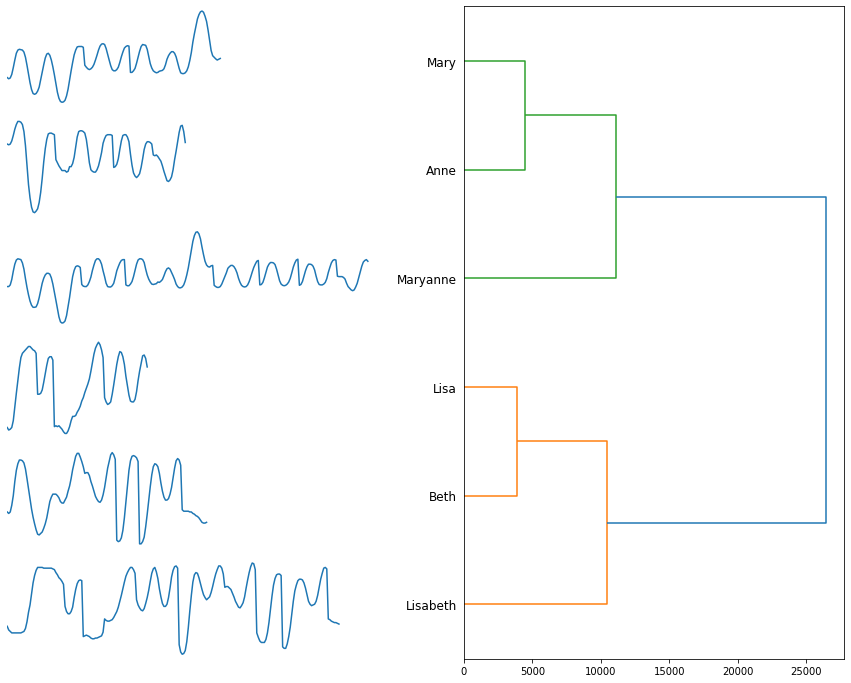

In [22]:
plot_cluster(euc_1)

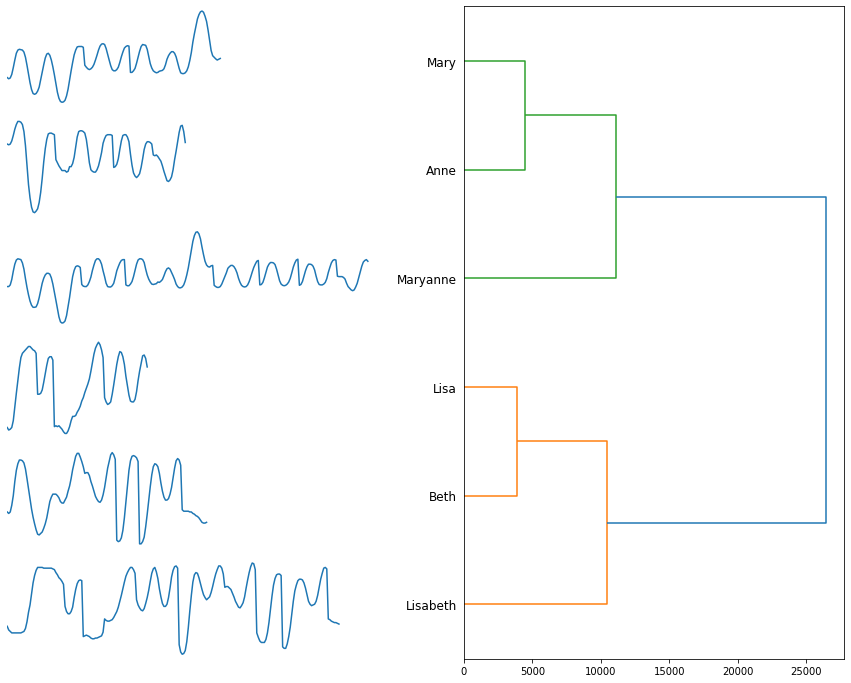

In [23]:
plot_cluster(euc_2)

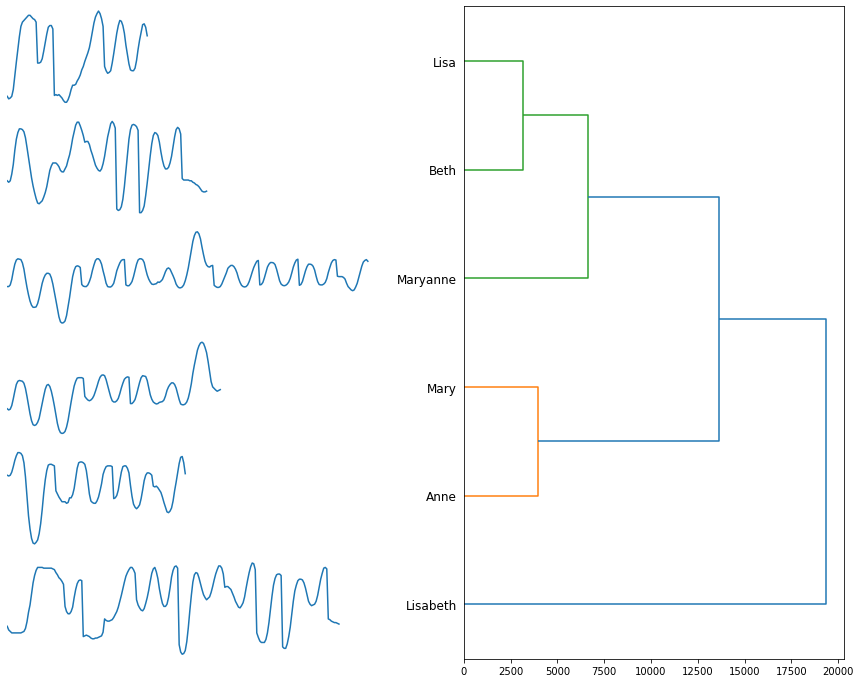

In [24]:
plot_cluster(euc_3)

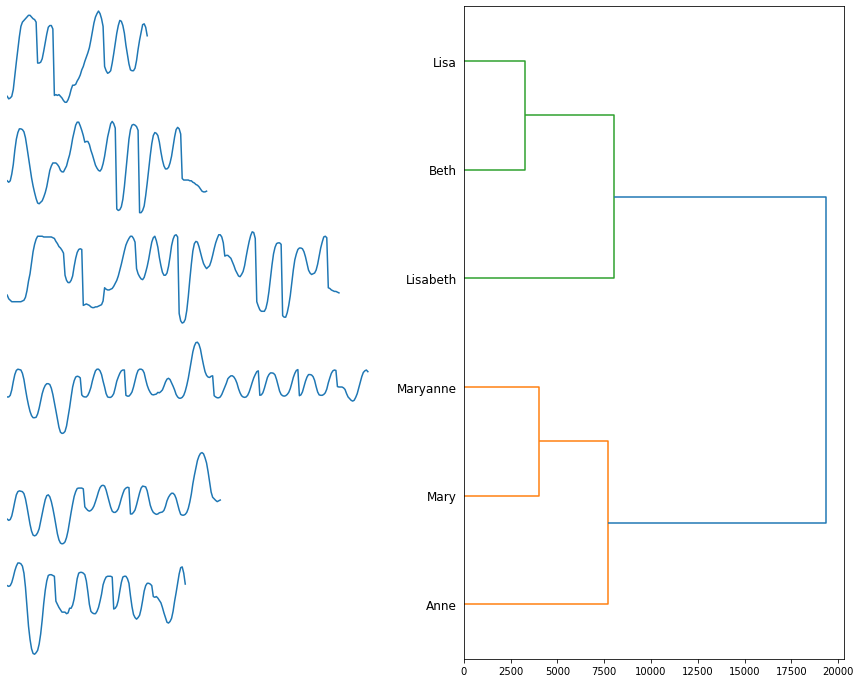

In [25]:
plot_cluster(euc_4)

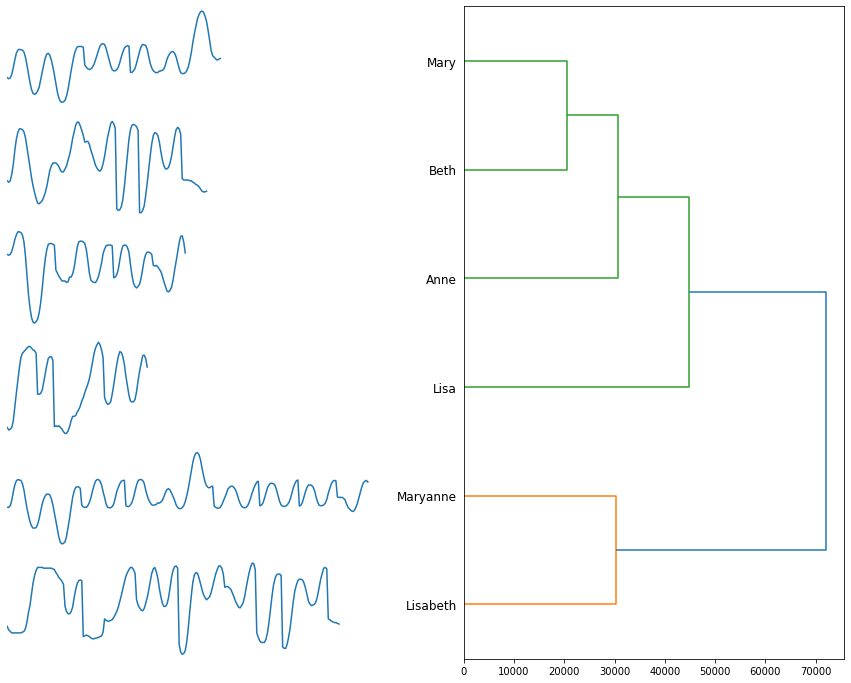

In [26]:
plot_cluster(euc_5)

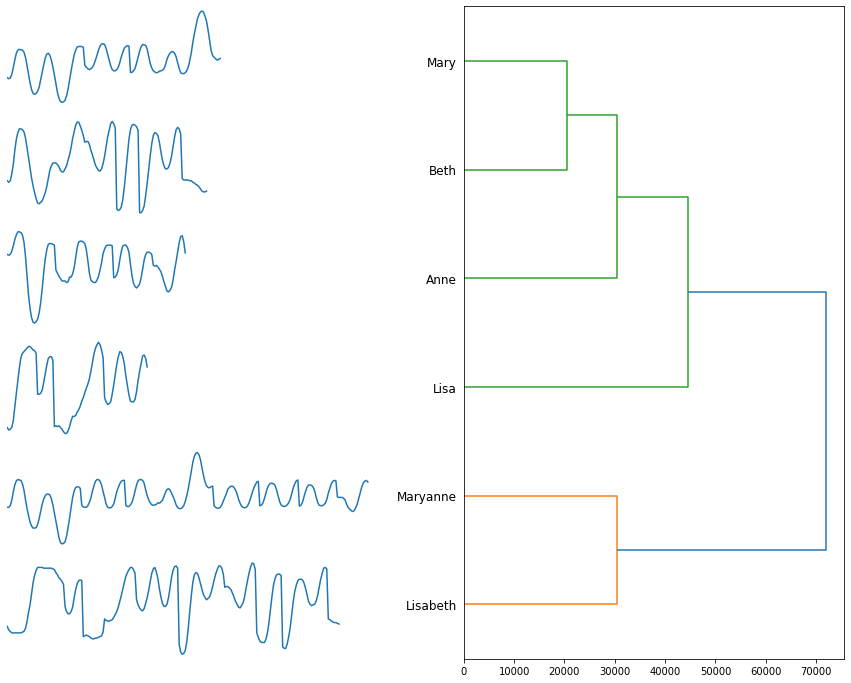

In [27]:
plot_cluster(euc_6)

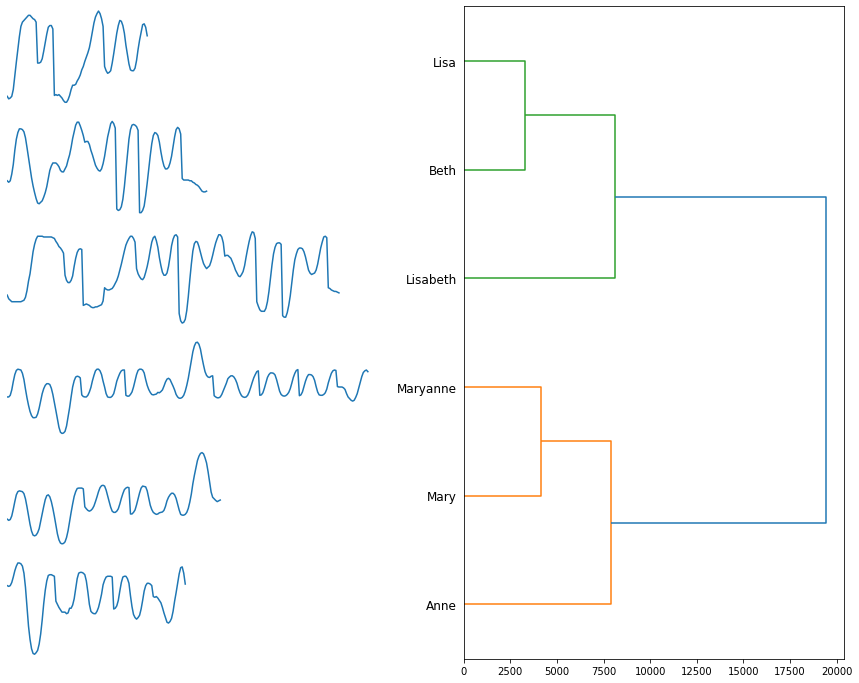

In [28]:
plot_cluster(euc_7)

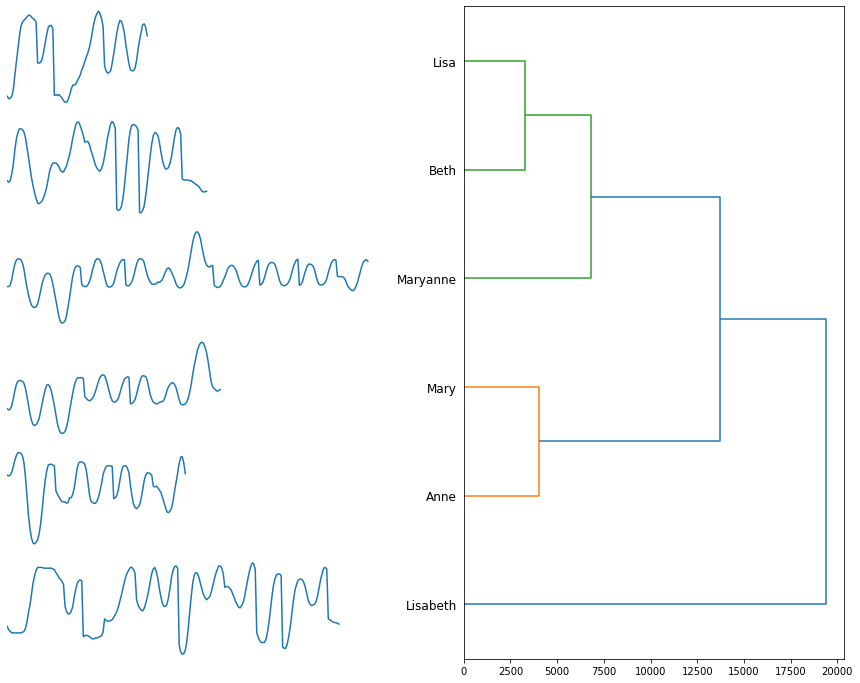

In [29]:
plot_cluster(euc_8)

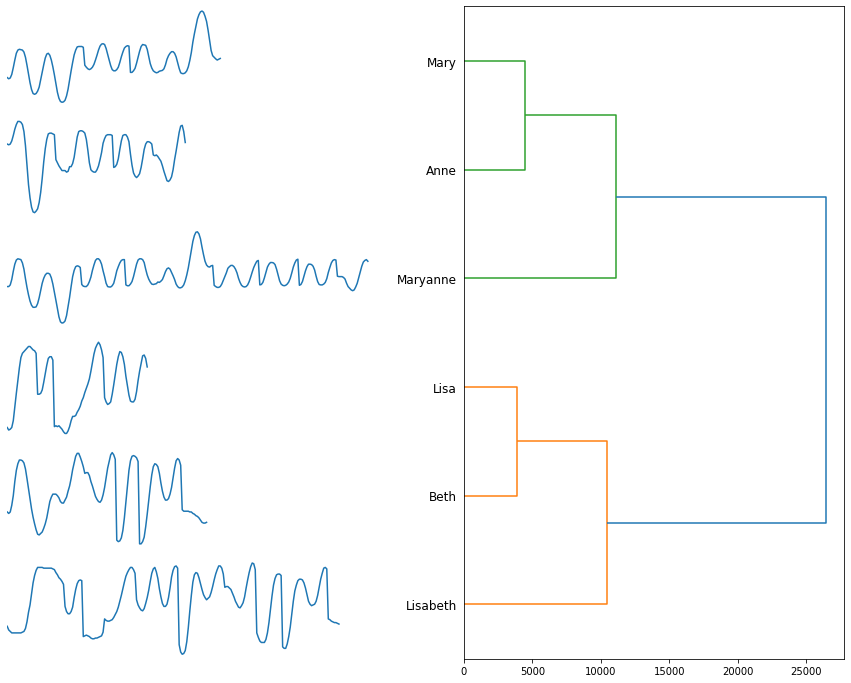

In [34]:
plot_cluster(euc_9)

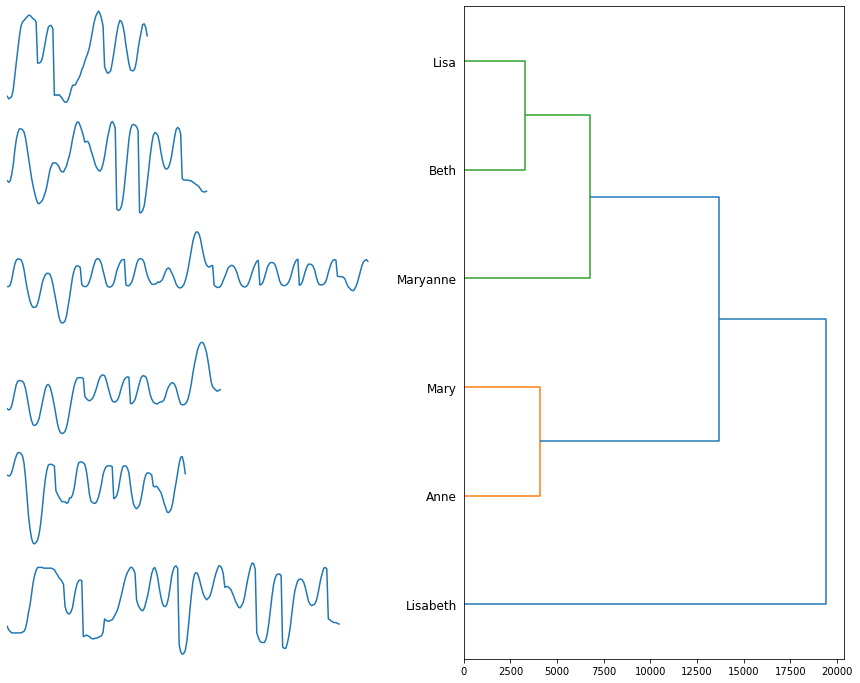

In [35]:
plot_cluster(euc_10)